In [4]:
import numpy as np
import sys
import time
import h5py as h5
import os
import pickle
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt

# os.environ['NUMBAPRO_CUDALIB'] = r"C:\Users\hyli93\Anaconda3\envs\mypython3\Library\bin"
sys.path.append(r"C:\Users\hyli93\Documents\GitHub\CrystalDiffraction")
display(HTML("<style>.container { width:90% !important; }</style>"))

from numba import cuda
from CrystalDiff import util, pulse, auxiliary, gutil

In [17]:
############################################################################################################
# ----------------------------------------------------------------------------------------------------------
#
#                       Step 1: Prepare the devices and pulses
#
# ----------------------------------------------------------------------------------------------------------
############################################################################################################
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                               Crystal
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Set up bragg angle
h_length = 2. * np.pi / (1.9201 * 1e-4)
hlen_vals = np.array([h_length, ] * 4)

bragg_angle = np.radians(18.836)

# Set up the angles
theta = np.pi / 2. + bragg_angle
theta_vals = [theta,
              np.pi + theta,
              - theta,
              np.pi - theta]
rho = bragg_angle - np.pi / 2.
rho_vals = [rho,
            np.pi + rho,
            - rho,
            np.pi - rho]

tau_vals = [0.,
            np.radians(10.),
            -np.radians(10.),
            0.,
            ]

# Set up the surface position
surface_points = [np.zeros(3, dtype=np.float64) for x in range(4)]

# Initialize the crystals
crystal_list = auxiliary.get_crystal_list_lcls2(num=4,
                                                hlen_vals=hlen_vals,
                                                rho_vals=rho_vals,
                                                theta_vals=theta_vals,
                                                tau_vals=tau_vals,
                                                surface_points=surface_points,
                                                chi0=complex(-0.97631E-05, 0.14871E-06),
                                                chih_sigma=complex(0.59310E-05, -0.14320E-06),
                                                chihbar_sigma=complex(0.59310E-05, -0.14320E-06),
                                                chih_pi=complex(0.46945E-05, -0.11201E-06),
                                                chihbar_pi=complex(0.46945E-05, -0.11201E-06)
                                                )

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                               Pulse
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# From FWHM to sigma
fwhm = 500.  # um
sigma = fwhm / 2 / np.sqrt(2 * np.log(2))
sigma_t = sigma / util.c
print("The corresponding sigma in the definition of the pulse should be {:.2f} fs.".format(sigma_t))

# Set up the pulse
my_pulse = pulse.GaussianPulse3D()

energy_center = 10.
k_len = util.kev_to_wave_number(energy=energy_center)

my_pulse.polar = np.array([0., 1., 0.], dtype=np.complex128)

my_pulse.k0 = np.array([0., 0., k_len])
my_pulse.n = my_pulse.k0 / util.l2_norm(my_pulse.k0)
my_pulse.omega0 = k_len * util.c

my_pulse.sigma_x = 100 #sigma_t
my_pulse.sigma_y = 100 #sigma_t  # fs
my_pulse.sigma_z = 1.  # fs
my_pulse.sigma_mat = np.diag(np.array([my_pulse.sigma_x ** 2,
                                       my_pulse.sigma_y ** 2,
                                       my_pulse.sigma_z ** 2], dtype=np.float64))
my_pulse.sigma_mat *= util.c ** 2

magnitude_peak = 1.
my_pulse.scaling = complex(my_pulse.sigma_x * my_pulse.sigma_y *
                           my_pulse.sigma_z * (util.c ** 3), 0.) * magnitude_peak

pre_length = 3000.
my_pulse.x0 = np.array([0., 0., -pre_length])

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Arrange the crystal separation
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
path_sections = [0., 2. * 1e4, 12. * 1e4, 2. * 1e4]

intersection_points, kout_vec_list = auxiliary.get_intersection_point(kin_vec=my_pulse.k0,
                                                                      path_sections=path_sections,
                                                                      crystal_list=crystal_list)

crystal_list = auxiliary.get_crystal_list_lcls2(num=4,
                                                hlen_vals=hlen_vals,
                                                rho_vals=rho_vals,
                                                theta_vals=theta_vals,
                                                tau_vals=tau_vals,
                                                surface_points=np.copy(intersection_points),
                                                chi0=complex(-0.97631E-05, 0.14871E-06),
                                                chih_sigma=complex(0.59310E-05, -0.14320E-06),
                                                chihbar_sigma=complex(0.59310E-05, -0.14320E-06),
                                                chih_pi=complex(0.46945E-05, -0.11201E-06),
                                                chihbar_pi=complex(0.46945E-05, -0.11201E-06)
                                                )

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Get the observation point
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
post_length = 6000.
observation = (intersection_points[-1] +
               post_length * kout_vec_list[-1] / util.l2_norm(kout_vec_list[-1]))

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                  Get the momentum mesh
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
number_x = 500
number_y = 500
number_z = 1000
kx_grid, ky_grid, kz_grid, axis_info = auxiliary.get_k_mesh_3d(number_x=number_x,
                                                               number_y=number_y,
                                                               number_z=number_z,
                                                               delta_e_x=1e-3,
                                                               delta_e_y=1e-3,
                                                               delta_e_z=1e-3)
kz_grid += k_len

total_path = (pre_length + post_length +
              util.get_total_path_length(intersection_point_list=intersection_points))
print("The total propagation length is {:.2f}um.".format(total_path))

The corresponding sigma in the definition of the pulse should be 708.26 fs.
The total propagation length is 169000.00um.


In [18]:
for tes in crystal_list:
    #print(tes.h)
    print(tes.normal)

[ 0.         -0.94644659  0.32286043]
[ 0.17364818  0.93206794 -0.31795545]
[-0.17364818  0.93206794  0.31795545]
[ 0.         -0.94644659 -0.32286043]


In [23]:
# Generate  a list
kvec_list = np.zeros((number_y, 3))
kvec_list[:,0] = kx_grid[250]
kvec_list[:,1] = ky_grid
kvec_list[:,2] = kz_grid[500]

# Get kout_list
kout_list = np.zeros((number_y, 3))

for l in range(number_y):
    _, tmp            = auxiliary.get_intersection_point(kin_vec=kvec_list[l],
                                                         path_sections=path_sections,
                                                         crystal_list=crystal_list)
    
    kout_list[l] = tmp[-1]

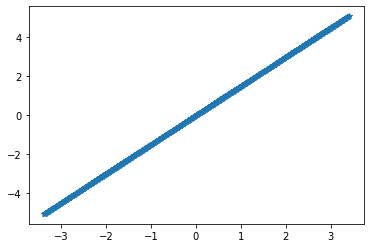

In [24]:
x = kout_list[:,0]
y = kout_list[:,1]
z = kout_list[:,2]

plt.plot(x, y, '*')
plt.show()